Lambda School Data Science

*Unit 4, Sprint 3, Module 3*

---

# Autoencoders

> An autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner.[1][2] The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore signal “noise”. Along with the reduction side, a reconstructing side is learnt, where the autoencoder tries to generate from the reduced encoding a representation as close as possible to its original input, hence its name. 

## Learning Objectives
*At the end of the lecture you should be to*:
* <a href="#p1">Part 1</a>: Describe the componenets of an autoencoder
* <a href="#p2">Part 2</a>: Train an autoencoder
* <a href="#p3">Part 3</a>: Apply an autoenocder to a basic information retrieval problem

__Problem:__ Is it possible to automatically represent an image as a fixed-sized vector even if it isn’t labeled?

__Solution:__ Use an autoencoder

Why do we need to represent an image as a fixed-sized vector do you ask? 

* __Information Retrieval__
    - [Reverse Image Search](https://en.wikipedia.org/wiki/Reverse_image_search)
    - [Recommendation Systems - Content Based Filtering](https://en.wikipedia.org/wiki/Recommender_system#Content-based_filtering)
* __Dimensionality Reduction__
    - [Feature Extraction](https://www.kaggle.com/c/vsb-power-line-fault-detection/discussion/78285)
    - [Manifold Learning](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction)

We've already seen *representation learning* when we talked about word embedding modelings during our NLP week. Today we're going to achieve a similiar goal on images using *autoencoders*. An autoencoder is a neural network that is trained to attempt to copy its input to its output. Usually they are restricted in ways that allow them to copy only approximately. The model often learns useful properties of the data, because it is forced to prioritize which aspecs of the input should be copied. The properties of autoencoders have made them an important part of modern generative modeling approaches. Consider autoencoders a special case of feed-forward networks (the kind we've been studying); backpropagation and gradient descent still work. 

# Autoencoder Architecture (Learn)
<a id="p1"></a>

## Overview

The *encoder* compresses the input data and the *decoder* does the reverse to produce the uncompressed version of the data to create a reconstruction of the input as accurately as possible:

<img src='https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png' width=800/>

The learning process gis described simply as minimizing a loss function: 
$ L(x, g(f(x))) $

- $L$ is a loss function penalizing $g(f(x))$ for being dissimiliar from $x$ (such as mean squared error)
- $f$ is the encoder function
- $g$ is the decoder function

## Follow Along--Architecture 1: Extremely Simple Autoencoder

In [ ]:
%load_ext tensorboard

In [ ]:
import tensorflow as tf
import numpy as np
import os
tf.random.set_seed(10)

URL_ = "https://github.com/LambdaSchool/DS-Unit-4-Sprint-2-Neural-Networks/blob/main/quickdraw10.npz?raw=true"

path_to_zip = tf.keras.utils.get_file('./quickdraw10.npz', origin=URL_, extract=False)

In [ ]:
data = np.load(path_to_zip)

X_train = data['arr_0']
y_train = data['arr_1']

print(X_train.shape)
print(y_train.shape)

(100000, 784)
(100000,)


In [ ]:
class_names = ['apple',
 'anvil',
 'airplane',
 'banana',
 'The Eiffel Tower',
 'The Mona Lisa',
 'The Great Wall of China',
 'alarm clock',
 'ant',
 'asparagus']

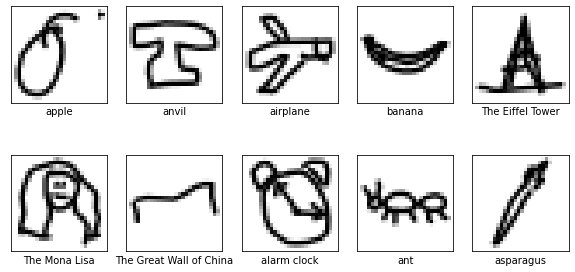

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
start = 0

for num, name in enumerate(class_names):
    plt.subplot(2,5, num+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[start].reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel(name)
    start += 10000
plt.show()

In [ ]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [ ]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [ ]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.compile(optimizer='nadam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_train = X_train.astype('float32') / 255.
print(X_train.shape)

(100000, 784)


In [ ]:
import os
import datetime
from tensorflow.keras.callbacks import TensorBoard

stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2)
now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

logdir = os.path.join("logs", f"SimpleAutoencoder-{now}")
tensorboard = TensorBoard(log_dir=logdir)

autoencoder.fit(X_train, X_train,  # X_train twice!
                epochs=10000,
                batch_size=64,
                shuffle=True,
                validation_split=.2,
                verbose = True,
                callbacks=[stop, tensorboard])

Epoch 1/10000
1250/1250 [==============================] - 7s 3ms/step - loss: 0.3543 - val_loss: 0.2410
Epoch 2/10000
1250/1250 [==============================] - 3s 2ms/step - loss: 0.2364 - val_loss: 0.2265
Epoch 3/10000
1250/1250 [==============================] - 3s 2ms/step - loss: 0.2266 - val_loss: 0.2233
Epoch 4/10000
1250/1250 [==============================] - 3s 2ms/step - loss: 0.2243 - val_loss: 0.2225
Epoch 5/10000
1250/1250 [==============================] - 3s 2ms/step - loss: 0.2223 - val_loss: 0.2219
Epoch 6/10000
1250/1250 [==============================] - 3s 2ms/step - loss: 0.2221 - val_loss: 0.2214
Epoch 7/10000
1250/1250 [==============================] - 3s 2ms/step - loss: 0.2218 - val_loss: 0.2211


In [ ]:
%tensorboard --logdir ./logs

In [ ]:
# encode and decode some digits
decoded_imgs = autoencoder(X_train)

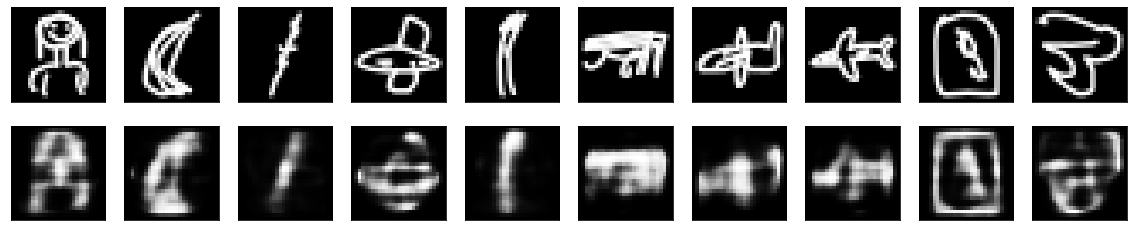

In [ ]:
# use Matplotlib 
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Challenge

Expected to talk about the components of autoencoder and their purpose. 

# Train an Autoencoder (Learn)
<a id="p2"></a>

## Overview

As long as our architecture maintains an hourglass shape, we can continue to add layers and create a deeper network. 

## Follow Along

## Architecture 2: Deep Autoencoder

In [ ]:
input_img = Input(shape=(784,))
encoded_1 = Dense(256, activation='relu')(input_img)
encoded_2 = Dense(64, activation='relu')(encoded_1)

# Latent Representation 
encoded = Dense(32, activation='relu')(encoded_2)

# Decoder
decoder_1 = Dense(64, activation='relu')(encoded)
decoder_2 = Dense(256, activation='relu')(decoder_1)
decoder = Dense(784, activation='sigmoid')(decoder_2)

autoencoder = Model(input_img, decoder)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_6 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_7 (Dense)              (None, 784)               2014

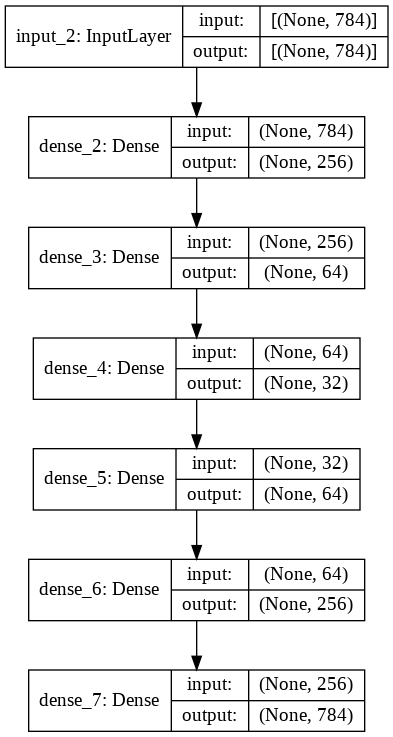

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(autoencoder, show_shapes=True)

In [ ]:
# compile & fit model
autoencoder.compile(optimizer='nadam', loss='binary_crossentropy')

stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2)
now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

logdir = os.path.join("logs", f"DeepAutoencoder-{now}")
tensorboard = TensorBoard(log_dir=logdir)

autoencoder.fit(X_train, X_train,  # X_train twice!
                epochs=10000,
                batch_size=64,
                shuffle=True,
                validation_split=.2,
                verbose = True,
                callbacks=[stop, tensorboard])

Epoch 1/10000
1250/1250 [==============================] - 6s 4ms/step - loss: 0.3216 - val_loss: 0.2438
Epoch 2/10000
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2388 - val_loss: 0.2291
Epoch 3/10000
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2236 - val_loss: 0.2156
Epoch 4/10000
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2137 - val_loss: 0.2082
Epoch 5/10000
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2080 - val_loss: 0.2030
Epoch 6/10000
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2018 - val_loss: 0.1993
Epoch 7/10000
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1986 - val_loss: 0.1960
Epoch 8/10000
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1953 - val_loss: 0.1940
Epoch 9/10000
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1936 - val_loss: 0.1916
Epoch 10/10000
1250/1250 [=============================

In [ ]:
decoded_imgs = autoencoder(X_train)

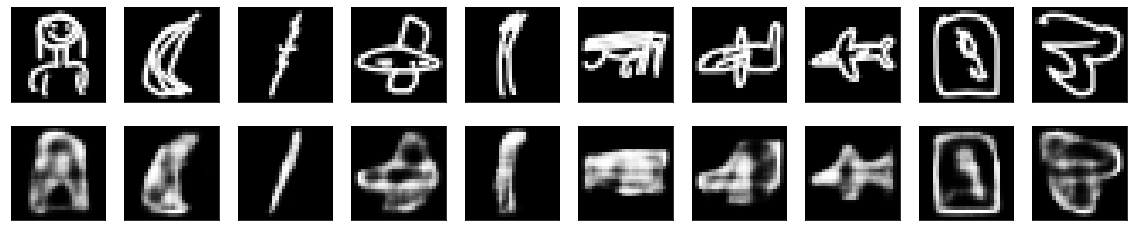

In [ ]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Architecture 3: Convolutional autoencoder

> Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

> Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

# Create Model 
input_img = Input(shape=(28, 28, 1))

x = Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(2, (3, 3), activation='relu', padding='same')(x)

# Latent Representation is (4, 4, 2) i.e. 32-dimensional representation
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(2, (3,3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='nadam', 
                    loss='binary_crossentropy')
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 2)           146       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 2)           0   

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_train.shape

(100000, 28, 28, 1)

In [ ]:
stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)
now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join("logs", f"ConvAutoencoder-{now}")
tensorboard = TensorBoard(log_dir=logdir)

autoencoder.fit(X_train, X_train,  # X_train twice!
                epochs=100,
                batch_size=64,
                shuffle=True,
                validation_split=0.2,
                verbose = True,
                callbacks=[stop, tensorboard])

Epoch 1/100
1250/1250 [==============================] - 39s 7ms/step - loss: 0.3583 - val_loss: 0.2769
Epoch 2/100
1250/1250 [==============================] - 7s 6ms/step - loss: 0.2753 - val_loss: 0.2636
Epoch 3/100
1250/1250 [==============================] - 7s 6ms/step - loss: 0.2628 - val_loss: 0.2573
Epoch 4/100
1250/1250 [==============================] - 7s 6ms/step - loss: 0.2554 - val_loss: 0.2532
Epoch 5/100
1250/1250 [==============================] - 7s 6ms/step - loss: 0.2490 - val_loss: 0.2442
Epoch 6/100
1250/1250 [==============================] - 7s 6ms/step - loss: 0.2451 - val_loss: 0.2419
Epoch 7/100
1250/1250 [==============================] - 7s 6ms/step - loss: 0.2417 - val_loss: 0.2387
Epoch 8/100
1250/1250 [==============================] - 7s 6ms/step - loss: 0.2399 - val_loss: 0.2389
Epoch 9/100
1250/1250 [==============================] - 7s 6ms/step - loss: 0.2384 - val_loss: 0.2352
Epoch 10/100
1250/1250 [==============================] - 7s 6ms/step - 

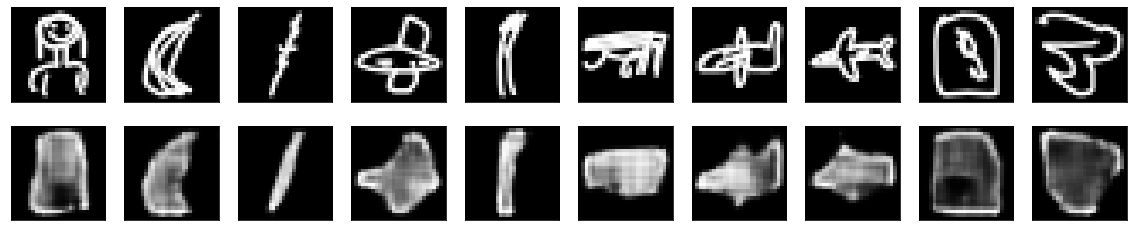

In [ ]:
decoded_imgs = autoencoder.predict(X_train)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### Visualization of the Representations

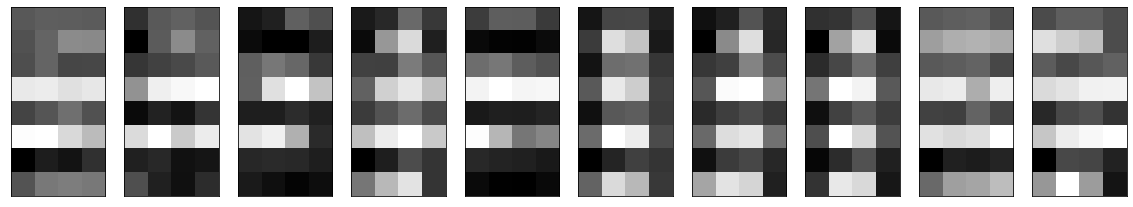

In [ ]:
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(X_train)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 2).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
encoded_imgs[0]

array([[[0.6838341 , 0.6326386 ],
        [0.6018213 , 1.7911365 ],
        [0.52637964, 1.9488703 ],
        [0.        , 0.64231217]],

       [[0.72576636, 0.7731729 ],
        [0.7709471 , 1.8162333 ],
        [0.66098833, 1.9677439 ],
        [0.22454277, 0.9244423 ]],

       [[0.7188121 , 1.072658  ],
        [0.54215574, 1.7285188 ],
        [0.85528123, 1.6746001 ],
        [0.14783809, 0.96515024]],

       [[0.7004607 , 1.0589764 ],
        [0.5528121 , 1.780835  ],
        [0.63119596, 1.4400985 ],
        [0.3691747 , 0.9224829 ]]], dtype=float32)

## Challenge

You will train an autoencoder at some point in the near future. 

# Information Retrieval with Autoencoders (Learn)
<a id="p3"></a>

## Overview

A common usecase for autoencoders is for reverse image search. Let's try to draw an image and see what's most similiar in our dataset. 

To accomplish this we will need to slice our autoendoer in half to extract our reduced features. :) 

## Follow Along

In [ ]:
from tensorflow.keras.layers import Flatten

# To run with the Deep Autoencoder (remove the first line below)
encoded = Flatten()(encoded)
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(X_train)

In [ ]:
encoded_imgs[0].T

array([0.6838341 , 0.6326386 , 0.6018213 , 1.7911365 , 0.52637964,
       1.9488703 , 0.        , 0.64231217, 0.72576636, 0.7731729 ,
       0.7709471 , 1.8162333 , 0.66098833, 1.9677439 , 0.22454277,
       0.9244423 , 0.7188121 , 1.072658  , 0.54215574, 1.7285188 ,
       0.85528123, 1.6746001 , 0.14783809, 0.96515024, 0.7004607 ,
       1.0589764 , 0.5528121 , 1.780835  , 0.63119596, 1.4400985 ,
       0.3691747 , 0.9224829 ], dtype=float32)

In [ ]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=10, algorithm='ball_tree')
nn.fit(encoded_imgs)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [ ]:
encoded_imgs[0].shape

(32,)

In [ ]:
encoded_imgs[0].reshape(1,-1).shape

(1, 32)

In [ ]:
close_image_idx = nn.kneighbors(encoded_imgs[0].reshape(1,-1))
close_image_idx

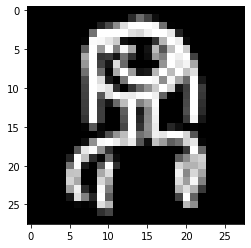

In [ ]:
plt.imshow(X_train[0].reshape(28,28));

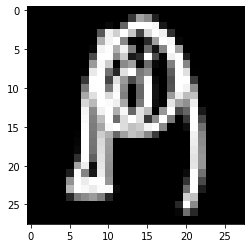

In [ ]:
plt.imshow(X_train[close_image_idx[1][0][1]].reshape(28,28));

## Challenge

You should already be familiar with KNN and similarity queries, so the key component of this section is know what to 'slice' from your autoencoder (the encoder) to extract features from your data. 

# Review

* <a href="#p1">Part 1</a>: Describe the componenets of an autoencoder
    - Enocder
    - Decoder
* <a href="#p2">Part 2</a>: Train an autoencoder
    - Can do in Keras Easily
    - Can use a variety of architectures
    - Architectures must follow hourglass shape
* <a href="#p3">Part 3</a>: Apply an autoenocder to a basic information retrieval problem
    - Extract just the encoder to use for various tasks
    - AE ares good for dimensionality reduction, reverse image search, and may more things. 


# Sources

__References__
- [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Deep Learning Cookbook](http://shop.oreilly.com/product/0636920097471.do)

__Additional Material__